# **GNN_Energy.ipynb: Energy prediction for EIC Det2 KLM**
This notebook walks through the steps of loading data, training and testing a GNN for energy prediction tasks

In [1]:
# import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import matplotlib.pyplot as plot
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.nn import GraphConv,SumPooling,GINConv,AvgPooling,MaxPooling
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm
import matplotlib.pyplot as plot
from datetime import datetime as datetime
current_date = datetime.now().strftime("%B_%d")
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.spatial import ConvexHull
from GNN_util import process_df_vectorized,create_directory,HitDataset,create_fast_edge_lists,visualize_detector_graph,GIN,train_GNN,test_GNN,calculate_bin_rmse,get_text_positions,get_min_max_of_graph_dataset
from torchviz import make_dot

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## **Load in Data**
The data is stored as pandas dataframes where each row is a hit in the detector

In [2]:
particle = "neutron"

num_dfs = 400
dfs = []
for i in range(0,0 + num_dfs):
    try: 
        new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/neutron_0_5GeV_to_5GeV50events_run_3_{i}.csv") 
#         new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/kaon0L_0_5GeV_to_5GeV50events_run_2_{i}.csv") 
    except FileNotFoundError as e:
        # Skip files that failed for some reason...
        # I think these files fail due to DCC issues?
        print(f"skipping file #{i}...")
        continue
    new_df["file_idx"] = i
    dfs.append(new_df)
if(len(dfs) > 1):
    data = pd.concat(dfs)
else:
    data = dfs[0]

skipping file #19...
skipping file #154...
skipping file #279...


## **Isolate hits in one section of detector**

Because we sometimes get backscattering and other weird detector effects, we want to train the GNN on a cluster of events that are all together, and treat hits that are far away as noise. This implementation allows the user to set how far away the hits can be and still be clustered together

In [4]:
# Plot the data
modified_df = process_df_vectorized(data, cone_angle_deg = 40)

## **Define the dataset class for easy management**

The HitDataset class inherits from the DGLDataset. The required member functions are the init method, process, getitem, and len.

In [20]:
class HitDataset(DGLDataset):
    def __init__(self, data, filter_events,connection_mode = "kNN",max_distance = 0.5,k = 6):
        self.data = data
        self.filter_events = filter_events
        self.max_distance = max_distance
        self.event_data = torch.tensor([])
        self.connection_mode = connection_mode
        self.k = k
        self.dfs = []
        self.mass_dict = {
            130 : 0.497611,
            2112  : 0.939565,
            211 : 0.139570
                         }
        super().__init__(name = "KLM_reco")
    def get_max_distance_edges(self,curr_event):
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values

        # Create coordinate matrices
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences

        # Compute distances in one go
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Create mask for valid edges (upper triangle only to avoid duplicates)
        upper_mask = (distances < self.max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)

        # Get edge indices for upper triangle
        src_upper, dst_upper = np.where(upper_mask)

        # Create the bidirectional edges
        sources = np.concatenate([src_upper, dst_upper])
        destinations = np.concatenate([dst_upper, src_upper])
        return sources,destinations
    def get_knn_edges(self,curr_event):
        """ 
        Given x and y coordinates of nodes, compute edges for a k-NN graph.

        Args:
            x (numpy array): x-coordinates of nodes.
            y (numpy array): y-coordinates of nodes.
            k (int): Number of nearest neighbors.

        Returns:
            sources (numpy array): List of source nodes.
            destinations (numpy array): List of destination nodes.
        """
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values
        n = len(x)

        # The first notation with "np.newaxis" is the same as tensor.unsqueeze(-1)
        # It puts each value in its own dimension, like
        # x = np.arrayy([[a],[b],[c]]), so size is (N,1) rather than (N)
        # The second notation (x[np.newaxis,:]) just puts the array in another array so that the size is (1,N
        # rather than (N)
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]
        
        # distances has shape (N,N) - matrix where the diagonal is 0, each entry is the distance between
        # the ith (column idx) node and the jth (row idx) node
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Get the indices of the k nearest neighbors for each node (excluding self-connections)
        # argsort sorts each row by the distance and returns the sorted indices
        # We use the [:,1:k+1] to take the first k indices besides the lowest (which is the diagonal self connection)
        knn_indices = np.argsort(distances, axis=1)[:, 1:self.k+1]

        # Create source and destination lists
        sources = np.concatenate([np.repeat(np.arange(n), self.k),knn_indices.flatten()])
        destinations = np.concatenate([knn_indices.flatten(),np.repeat(np.arange(n), self.k)])

        return sources, destinations
        
    def process(self):
        events_group = self.data.groupby(["event_idx","file_idx"])
        self.labels = torch.tensor([])
        self.graphs = []
        it_idx = 0
        for event_idx in events_group.groups:
            curr_event = events_group.get_group(event_idx)
            nhits = len(curr_event)
            '''FIRST FILTER FOR EVENTS'''
            if(self.filter_events):
                ModifiedTrueID_unique = np.array(curr_event['ModifiedTrueID'].unique())
                valid_ModifiedTrueID_unique = ModifiedTrueID_unique[ModifiedTrueID_unique != -1]
                print("event #{}, trueID: {}".format(event_idx, curr_event['trueID']))
                #skip events with multiple valid trueIDs
                if(len(valid_ModifiedTrueID_unique) > 1):
                    print("Too many valid ModifiedTrueID, skipping...")
                    continue
            
                #skip events with no valid ModififiedTrueIDs
#                 if(len(valid_ModifiedTrueID_unique) == 0):
#                     print("No valid ModifiedTrueIDs, skipping...")
#                     continue
                # Remove rows that are hits outside of the cone
                curr_event = curr_event[curr_event.ModifiedTrueID != -1]
                nhits = len(curr_event)
            # Skip graphs with only 1 hit (or 0)
            if(nhits <2):
#                 print("only 1 hit, skipping...")
                continue;
            elif(nhits <self.k):
                sources = np.concatenate([np.repeat(np.arange(nhits),nhits),np.tile(np.arange(nhits),nhits)])
                destinations = np.concatenate([np.tile(np.arange(nhits),nhits),np.repeat(np.arange(nhits),nhits)])
            else:
                if(self.connection_mode == "max distance"):
                    sources, destinations = self.get_max_distance_edges(curr_event)
                elif(self.connection_mode == "kNN"):
                    sources, destinations = self.get_knn_edges(curr_event)
            g = dgl.graph((sources, destinations), num_nodes=nhits)
            #Want to predict energy
            try:
                mass = self.mass_dict[curr_event["truePID"].to_numpy()[0]]
            except Exception as e:
                truePID = curr_event["truePID"].to_numpy()[0]
                print(f"Exception: {e}")
                print(f"Particle with truePID of {truePID} not in dictionary. Skipping...")
                continue
            momentum = curr_event["P"].to_numpy()[0]
            energy = np.sqrt(mass**2 + momentum**2)
            label = torch.tensor(energy)
            strip_x = (curr_event["strip_x"].to_numpy() / 3000)
            strip_y = (curr_event["strip_y"].to_numpy() / 3000)
            radial_distance = torch.tensor(np.sqrt( strip_x** 2 + strip_y ** 2))
            '''VERSION LABEL INCLUDING EVENT FEATURES'''
            # Since this is the version with both SiPM in one hit/node, we have 2 times and charges
            # I hope that doing this will avoid making the NN learn that two hits at the same position are 
            # closely related
            feats = np.stack((
                strip_x,strip_y, radial_distance,
                curr_event["Time0"].to_numpy() / 5,
                curr_event["Charge0"].to_numpy(),
                curr_event["Time1"].to_numpy() / 5,
                curr_event["Charge1"].to_numpy(),
                curr_event["stave_idx"].to_numpy(),
                curr_event["layer_idx"].to_numpy(),
                curr_event["segment_idx"].to_numpy()
            ),axis = -1)
            g.ndata["feat"] = torch.tensor(feats)#.unsqueeze(-1)
            self.dfs.append(curr_event)
            # Sort hits by time

            # Basic features
            total_charge = curr_event['Charge1'].sum() + curr_event['Charge0'].sum()
            max_charge = max([curr_event['Charge1'].max(),curr_event['Charge0'].max()])
            n_hits = len(curr_event)

            # Spatial features
#             hit_coords = curr_event[['strip_x', 'strip_y']].values
            # Feature vector for this event
            event_features = torch.from_numpy(np.stack((label,
                total_charge,
                max_charge,
                n_hits

                ),axis = -1))
            if(self.labels.shape[0] == 0):
                self.labels = event_features
            else:
                self.labels = torch.vstack((self.labels,event_features))
            #add graph to dataset
            self.graphs.append(g)
            it_idx += 1
        self.dim_nfeats = self.graphs[0].ndata["feat"].shape[1]
        self.dim_event_feats = self.labels.shape[1] - 1
        self.labels = self.labels.clone().detach().float()

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [21]:
dataset = HitDataset(modified_df,True,connection_mode = "kNN",k = 6)
print("done")

event #(0, 0), trueID: 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
Name: trueID, dtype: int64
event #(0, 1), trueID: 1395    0
1396    0
1397    0
1398    0
1399    0
1400    0
1401    0
1402    0
1403    0
1404    0
1405    0
1406    0
1407    0
1408    0
1409    0
1410    0
1411    0
1412    0
1413    0
1414    0
1415    0
1416    0
1417    0
1418    0
1419    0
1420    0
1421    0
1422    0
Name: trueID, dtype: int64
event #(0, 2), trueID: 2883    0
2884    0
2885    0
2886    0
2887    0
2888    0
2889    0
2890    0
2891    0
2892    0
2893    0
2894    0
2895    0
2896    0
2897    0
2898    0
2899    0
2900    0
2901    0
2902    0
2903    0
2904    0
2905    0


KeyboardInterrupt



In [7]:
print(len(dataset))

19184


## **Optionally, we can visualize any of the input graphs below**

In [8]:
def visualize_detector_graph(dataset,graph_idx = 0, max_edges=1000, figsize=(6, 6)):
    """
    Visualizes the detector hits and their connections.
    
    Parameters:
    curr_event (pd.DataFrame): DataFrame containing 'strip_x' and 'strip_y' columns
    sources (np.array): Array of source node indices
    destinations (np.array): Array of destination node indices
    max_edges (int): Maximum number of edges to plot to avoid overcrowding
    figsize (tuple): Figure size in inches
    """
    
    fig, axs = plot.subplots(1,2,figsize = (13,6))
    graph = dataset[graph_idx][0]
    curr_event = dataset.dfs[graph_idx]
    colors = curr_event['ModifiedTrueID'].apply(lambda x: 'red' if x == -1 else 'blue')
    sizes = curr_event['Charge0'] + curr_event['Charge1']
    # Create figure
    
    # Plot nodes (hits)
    axs[0].scatter(curr_event['strip_x'], curr_event['strip_y'], 
               c=colors, s=sizes * 1, alpha=0.4, label='Detector hits')
    axs[1].scatter(curr_event['strip_x'], curr_event['strip_y'], 
               c=colors, s=sizes * 1, alpha=0.4, label='Detector hits')
    sources,destinations = graph.edges()
    
    # Plot edges
    for src, dst in zip(sources, destinations):
        x1, y1 = curr_event.iloc[int(src)][['strip_x', 'strip_y']]
        x2, y2 = curr_event.iloc[int(dst)][['strip_x', 'strip_y']]
        axs[0].plot([x1, x2], [y1, y2], 'gray', alpha=0.1, linewidth=0.5)
        axs[1].plot([x1, x2], [y1, y2], 'gray', alpha=0.1, linewidth=0.5)
    # Add reference angle and highlight region
    reference_angle = curr_event['reference_angle'].iloc[0]  # Assuming one reference angle per event
    radius = 2900  # Radius of the detector
    
    # Calculate the coordinates for the line
    x_ref = radius * np.cos(np.radians(reference_angle))
    y_ref = radius * np.sin(np.radians(reference_angle))
#     plot.plot([0, x_ref], [0, y_ref], color='black', linewidth=3, label='Reference angle')
    
    # Highlight the 11-degree region
    theta_min = reference_angle - 40
    theta_max = reference_angle + 40
    
    # Calculate the coordinates for the line
    x_min = radius * np.cos(np.radians(theta_min))
    y_min = radius * np.sin(np.radians(theta_min))
    axs[0].plot([0, x_min], [0, y_min], color='orange', linewidth=1.5, label='Lower bound')
    
    # Calculate the coordinates for the line
    x_max = radius * np.cos(np.radians(theta_max))
    y_max = radius * np.sin(np.radians(theta_max))
    axs[0].plot([0, x_max], [0, y_max], color='orange', linewidth=1.5, label='Upper bound')
    
    # Add labels and title
    axs[0].set_xlabel('X Position')
    axs[0].set_ylabel('Y Position')
    n_edges = len(sources) / 2
    fig.suptitle(f'Detector Graph Visualization\n{len(curr_event)} nodes, {n_edges//2} edges')
    
    # Add text with statistics
    stats_text = f'Total nodes: {len(curr_event)}\n'
    stats_text += f'Total edges: {n_edges//2}\n'  # Divide by 2 because edges are bidirectional
    stats_text += f'Average degree: {n_edges/len(curr_event):.1f}'
    axs[1].text(0.02, 0.98, stats_text,
             transform=plot.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    axs[0].grid(True, alpha=0.3)
    axs[0].axis('equal')
    axs[0].set_xlim(-3070,3070)
    axs[0].set_ylim(-3070,3070)
    r = 1770
    for i in range(2):
        if(i == 0):
            r = 1770
        else:
            r = 2835
        angles = np.linspace(0, 2 * np.pi, 9)[:-1]
        angles += np.pi / 8
        R = r / np.cos(np.pi / 8)
        x = R * np.cos(angles)
        y = R * np.sin(angles)
        x = np.append(x, x[0])
        y = np.append(y, y[0])

    #         plot.figure(figsize=(6, 6))
        axs[0].plot(x, y, 'black')
        fig.savefig("plots/GNN/March_17_graph_viz.pdf")

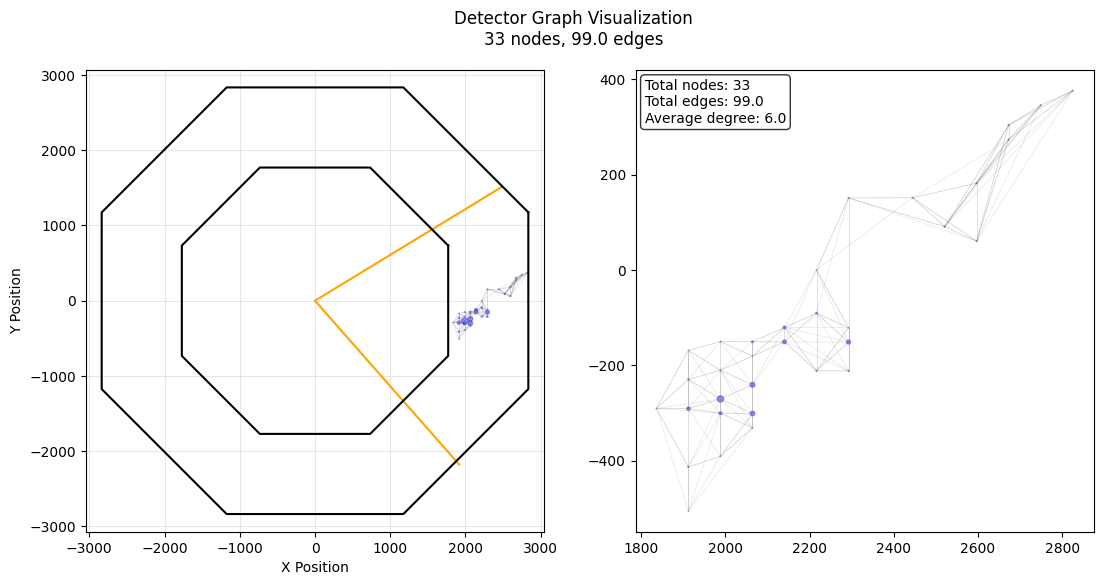

In [9]:
visualize_detector_graph(dataset,graph_idx = 2)

## **Define dataloader**

We use a dataloader to make batching easier, and to randomly split test and train

In [90]:
train_frac = 0.7
val_frac = 0.15
num_train = int(np.floor(len(dataset) * train_frac))
# num_train = 5
num_val = int(np.floor(len(dataset) * val_frac))
num_examples = len(dataset)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_val + num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_val + num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=20, drop_last=False
)

val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=20, drop_last=False
)

test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=20, drop_last=False
)

## **Initialize the model and define the optimizer/criterion**

In [91]:
run_num = 1
geometry_type = 2

In [92]:
# Test:
hidden_dim = 32
linear_capacity = 5
early_stopping_limit = 4
n_conv_layers = 2
n_linear_layers = 7
lr = 1e-4

In [93]:

class GIN(nn.Module):
    def __init__(self, in_feats, h_feats,num_event_feats,n_conv_layers = 2, n_linear_layers = 7,linear_capacity = 5, num_classes=1,pooling_type = "avg"):
        super(GIN, self).__init__()
        # Define the MLP for the GINConv layers
        conv_list = []
        for i in range(n_conv_layers):
            first_in = (in_feats if i == 0 else h_feats)
            mlp = nn.Sequential(
                nn.Linear(first_in, h_feats),
                nn.ReLU(),
                nn.Linear(h_feats, h_feats)
            )
            conv_list.append(GINConv(mlp))
        self.conv_list = nn.ModuleList(conv_list)
        
        # Define the GINConv layers
        
        linear_list = []
        for i in range(n_linear_layers):
            if(i == 0):
                in_feats = h_feats + num_event_feats
#                 in_feats = h_feats
#                 in_feats = num_event_feats
                out_feats = pow(2,linear_capacity + (n_linear_layers // 2))
            elif(i == n_linear_layers - 1):
                in_feats = out_feats
                out_feats = num_classes
            else:
                in_feats = out_feats
                out_feats = out_feats // (2 if (i %2) else 1)
            linear_list.append(nn.Linear(in_feats,out_feats))
        self.linear_list = nn.ModuleList(linear_list)
        
        # Graph pooling layer
        if(pooling_type == "avg"):
            self.pool = AvgPooling()
        elif(pooling_type == "sum"):
            self.pool = SumPooling()
        elif(pooling_type == "max"):
            self.pool = MaxPooling()
        else:
            print(f"Selected pooling type \"{pooling_type}\" not found. Resorting to default: AvgPooling")
            self.pool = AvgPooling()

    def forward(self, g, in_feat,event_feats):
        # Apply the first GINConv layer
        
        h = in_feat
        hidden_reps = []
        for i in range(len(self.conv_list)):
            h = self.conv_list[i](g,h)
            h = F.relu(h)
            hidden_reps.append(self.pool(g,h))
        
        # Pool the graph-level representation - gives one array of length n_feats
        hg = self.pool(g, h)
        for i in range(len(hidden_reps)):
            hg += hidden_reps[i]
#         print(f"event feats 0: {event_feats[:,0]}")
#         total_feats = event_feats.float()#.unsqueeze(-1)
        total_feats = torch.cat((hg,event_feats),axis = 1).float()
#         total_feats = hg
        for i in range(len(self.linear_list) - 1):
            total_feats = self.linear_list[i](total_feats)
            total_feats = F.relu(total_feats)
            
        #No activation on last linear layer:
        total_feats = self.linear_list[-1](total_feats)
        return total_feats

In [94]:
def train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs,early_stopping_limit,frame_plot_path = "",model_path = "",log_status = True):
    create_directory(model_path)
    val_mse = []
    val_mse_all = []
    train_losses = []
    train_losses_all = []
    early_stopping_dict = {
            "lowest_loss" : -1,
            "best_model_path" : "",
            "num_upticks" : 0,
            "best_epoch": 0
    }
    # 0: loss; 1: path; 2: # hits

    for epoch in range(n_epochs):
        model.train()
        num_train_batches = 0
        epoch_train_losses = 0.0
        train_preds = torch.tensor([])
        train_truths = torch.tensor([])
        
        for batched_graph, labels_w_event_feats in train_dataloader:
            labels = labels_w_event_feats[:,0]
            event_feats = labels_w_event_feats[:,1:]
#             print(f"labels: {labels}")
#             print(f"labels: {labels}\n event_feat: {event_feats}")
            pred = model(batched_graph, batched_graph.ndata["feat"].float(),event_feats)
            loss = criterion(pred, labels.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_losses+=loss.detach()
            train_losses_all.append(loss.detach())
            num_train_batches += 1
            train_preds = torch.cat([train_preds,pred.detach()])
            train_truths = torch.cat([train_truths,labels])
        # Average RMSE for the epoch
        this_epoch_loss = epoch_train_losses / num_train_batches
        train_losses.append(this_epoch_loss)
        # Testing phase
        model.eval()
        epoch_val_mse = 0.0
        num_val_batches = 0
        val_preds = torch.tensor([])
        val_truths = torch.tensor([])
        with torch.no_grad():  # Disable gradients for evaluation
            for batched_graph, labels_w_event_feats in val_dataloader:
                labels = labels_w_event_feats[:,0]
                event_feats = labels_w_event_feats[:,1:]
                pred = model(batched_graph, batched_graph.ndata["feat"].float(),event_feats)
                # Calculate RMSE for this batch
                batch_mse = criterion(pred, labels.unsqueeze(-1))
                epoch_val_mse += batch_mse
                num_val_batches += 1
                val_mse_all.append(batch_mse)
                val_preds = torch.cat([val_preds,pred])
                val_truths = torch.cat([val_truths,labels])

        # Average RMSE for the test set
        epoch_val_mse /= num_val_batches
        val_mse.append(epoch_val_mse)
        if(epoch %1 == 0):
            if(log_status):
                print(f"Epoch {epoch + 1}/{n_epochs} - Train loss:\t {this_epoch_loss:.4f}")
                print(f"Epoch {epoch + 1}/{n_epochs} - Validation Criterion:\t {epoch_val_mse:.4f}\n")
            if(frame_plot_path != ""):
                frame_fig, frame_axs = plot.subplots(1,1)
                frame_axs.plot([0,5],[0,5])
                frame_fig.suptitle("Test dataset results")
                frame_axs.scatter(val_truths,val_preds,alpha = 0.05,color = "red",label = "val")
    #             plot.scatter(train_truths,train_preds,alpha = 0.01,color = "blue",label = "train")
                frame_axs.set_xlabel("truths")
                frame_axs.set_ylabel("preds")
                frame_axs.text(3.1,1.3, f"Epoch #{epoch + 1}\nTrain, val loss: ({this_epoch_loss:.4f},{epoch_val_mse:.4f})")
                frame_fig.tight_layout()
                frame_fig.savefig(f"{frame_plot_path}epoch{epoch}.jpeg")
        
        if(epoch_val_mse.item() < early_stopping_dict["lowest_loss"] or early_stopping_dict["lowest_loss"] == -1):
            early_stopping_dict["lowest_loss"] = epoch_val_mse
            early_stopping_dict["best_model_path"] = f"{model_path}epoch_{epoch}.pth"
            early_stopping_dict["num_upticks"] = 0
            early_stopping_dict["best_epoch"] = epoch
            
            torch.save(model.state_dict(),early_stopping_dict["best_model_path"])
        elif(epoch_val_mse.item() > early_stopping_dict["lowest_loss"]):
            early_stopping_dict["num_upticks"] += 1
            if(log_status):
                print("Test loss increased, adding uptick")
        if(early_stopping_dict["num_upticks"] >= early_stopping_limit):
            # Stop training, load best model
            model.load_state_dict(torch.load(early_stopping_dict["best_model_path"]))
            torch.save(model.state_dict(),f"{model_path}best_model.pth")
            if(log_status):
                print("Stopping early, loading current model...")
            break
    return model, train_losses, val_mse, optimizer,early_stopping_dict["best_epoch"]

In [95]:
model = GIN(dataset.dim_nfeats,hidden_dim,dataset.dim_event_feats,n_conv_layers = n_conv_layers, n_linear_layers = n_linear_layers,linear_capacity = linear_capacity)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
# criterion = weighted_mse_loss

*Now we can actually train the model*

In [96]:
model_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/models/{current_date}/energy_only/"

In [97]:
n_epochs = 300
trained_model, train_losses, val_losses, optimizer,best_epoch = train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs, early_stopping_limit, model_path = model_path)

Epoch 1/300 - Train loss:	 1.1435
Epoch 1/300 - Validation Criterion:	 0.6214

Epoch 2/300 - Train loss:	 0.5541
Epoch 2/300 - Validation Criterion:	 0.5662

Epoch 3/300 - Train loss:	 0.5047
Epoch 3/300 - Validation Criterion:	 0.4546

Epoch 4/300 - Train loss:	 0.4630
Epoch 4/300 - Validation Criterion:	 0.4460

Epoch 5/300 - Train loss:	 0.4502
Epoch 5/300 - Validation Criterion:	 0.4508

Test loss increased, adding uptick
Epoch 6/300 - Train loss:	 0.4285
Epoch 6/300 - Validation Criterion:	 0.4143

Epoch 7/300 - Train loss:	 0.4232
Epoch 7/300 - Validation Criterion:	 0.4355

Test loss increased, adding uptick
Epoch 8/300 - Train loss:	 0.4155
Epoch 8/300 - Validation Criterion:	 0.4062

Epoch 9/300 - Train loss:	 0.4072
Epoch 9/300 - Validation Criterion:	 0.4084

Test loss increased, adding uptick
Epoch 10/300 - Train loss:	 0.4064
Epoch 10/300 - Validation Criterion:	 0.4145

Test loss increased, adding uptick
Epoch 11/300 - Train loss:	 0.3988
Epoch 11/300 - Validation Criteri

## **Plot training and val loss on log scale**

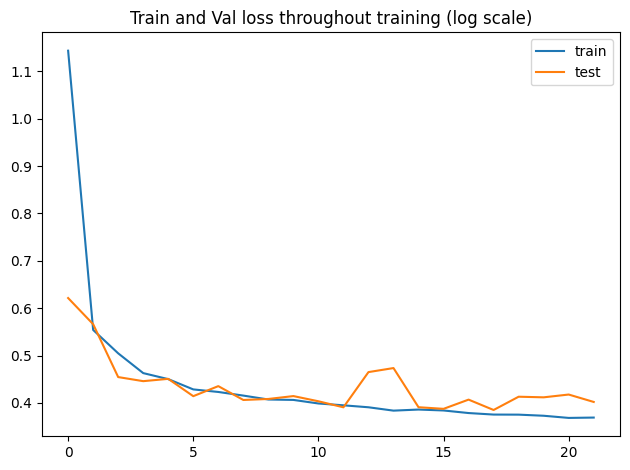

In [98]:
plot.plot(train_losses,label = "train")
plot.title("Train and Val loss throughout training (log scale)")
plot.plot(val_losses, label = "test")
plot.legend()
plot.tight_layout()

## **Evaluate model on test dataset**

Now we can check the RMSE and across the whole test dataset and visualize the result

RMSE: 0.6083187460899353


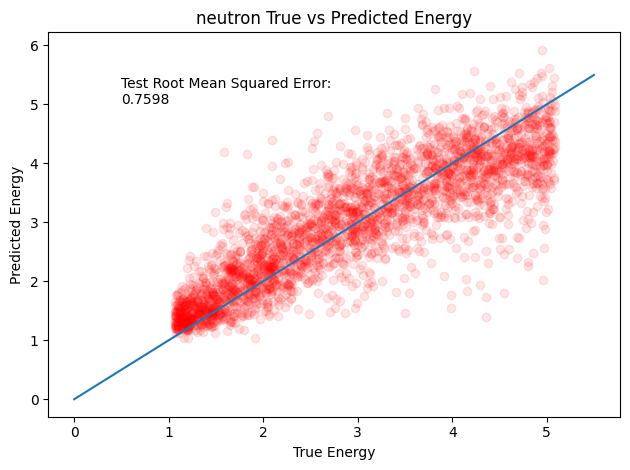

In [99]:
test_truths, test_preds, test_rmse = test_GNN(trained_model, test_dataloader)

plot.plot([0,5.5],[0,5.5])
plot.title(f"{particle} True vs Predicted Energy")
plot.scatter(test_truths,test_preds,alpha = 0.1,color = "r")
plot.xlabel("True Energy")
plot.ylabel("Predicted Energy")
plot.text(0.5,5,f"Test Root Mean Squared Error:\n{test_mse:0.4f}")
plot.tight_layout()
# plot.ylim(1,2)
# plot.xlim(1,2)
# plot.savefig("plots/GNN/March_17_predsvtruth.jpeg")

# Binned RMSE

/tmp/ipykernel_3344748/2810651372.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return A / np.sqrt(x)


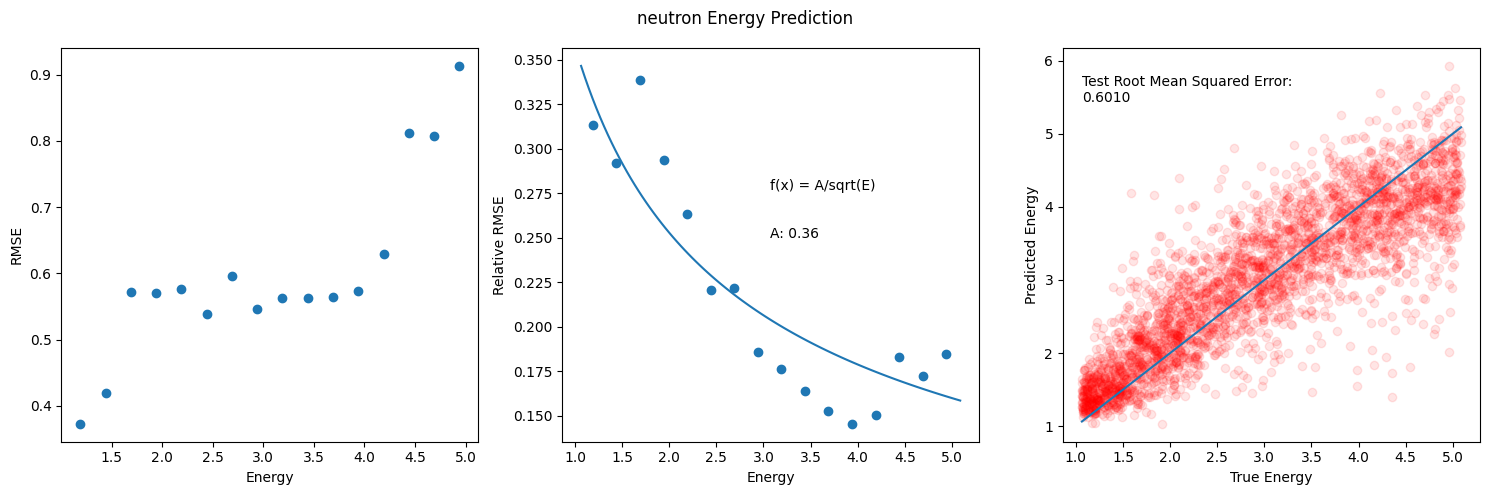

In [100]:
bin_min, bin_max = get_min_max_of_graph_dataset(dataset)

rmse_per_bin = calculate_bin_rmse(test_dataloader, model,bin_width = 0.25, bin_min = bin_min, bin_max = bin_max)

bin_centers = np.array(list(rmse_per_bin.keys()))
rmse = np.array(list(rmse_per_bin.values()))
rel_rmse = rmse / bin_centers

rel_rmse_x,rel_rmse_y,scatter_x,scatter_y = get_text_positions(bin_centers,rel_rmse,test_truths,test_preds)

def func(x, A):
    return A / np.sqrt(x)
from scipy.optimize import curve_fit

params, cov = curve_fit(func, bin_centers, rel_rmse)
x_fit = np.linspace(bin_min, bin_max, 100)
y_fit = func(x_fit, params)

fig,axs = plot.subplots(1,3,figsize = (15,5))
fig.suptitle(f"{particle} Energy Prediction")
axs[0].scatter(rmse_per_bin.keys(),rmse_per_bin.values())
axs[0].set(xlabel="Energy",ylabel = "RMSE")
axs[1].scatter(rmse_per_bin.keys(),np.array(list(rmse_per_bin.values())) / np.array(list(rmse_per_bin.keys())))
axs[1].plot(x_fit,y_fit)
axs[1].set(xlabel="Energy",ylabel = "Relative RMSE")
axs[1].text(rel_rmse_x,rel_rmse_y,f"A: {params[0]:.2f}")
text_spacing = (max(rmse_per_bin.values()) - min(rmse_per_bin.values())) / 20
axs[1].text(rel_rmse_x,rel_rmse_y + text_spacing,f"f(x) = A/sqrt(E)")
axs[2].scatter(test_truths,test_preds,alpha = 0.1,color = "r")
axs[2].text(scatter_x,scatter_y,f"Test Root Mean Squared Error:\n{np.mean(list(rmse_per_bin.values())):0.4f}")
axs[2].plot([min(test_truths),max(test_truths)],[min(test_truths),max(test_truths)])
axs[2].set(xlabel = "True Energy",ylabel = "Predicted Energy")
fig.tight_layout()
plot.savefig(f"plots/GNN_results/{particle}_0_5GeV_to_5GeV50events_run_2.pdf")
# plot.savefig(f"plots/GNN/March_20_K_L_run_{run_num}_RMSE_k_6.pdf")